# Predicting House Sale Prices

## Setup

In [3]:
import pandas as pd
import matplotlib
import numpy as np

data = pd.read_csv('AmesHousing.txt',sep='\t')
# remove recommended outliers
data = data.drop(data[data['Gr Liv Area'] > 4000].index)
print(len(data))

2925


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def transform_features(df):  
    return df

def select_features(df):
    return df[['Gr Liv Area','SalePrice']]

def train_and_test(df):
    k=10
    
    #split data into train and test
    train = df[:1460]
    test = df[1460:]
    
    #select numerical columns
    num_train = train.select_dtypes(include=['integer','float'])
    num_test = test.select_dtypes(include=['integer','float'])
    
    features = num_train.columns.drop('SalePrice')
    
    #create and fit model to train data
    lr = LinearRegression()
    lr.fit(num_train[features],num_train['SalePrice'])
    predictions = lr.predict(num_test[features])
    mse = mean_squared_error(test['SalePrice'],predictions)
    rmse = np.sqrt(np.absolute(mse))
    return rmse

transformed_data = transform_features(data)
filtered_data = select_features(transformed_data)
rmse = train_and_test(filtered_data)
print(rmse)

53033.9121974


## Feature Engineering

First we'll take a look at columns to see what features leak information about the sale. Taking a look at [DataDocumentation.txt](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt), the following columns stand out:

- Mo Sold
- Yr Sold
- Sale Type
- Sale Condition

Additionally, the follow columns are not helpful in making preditions as they are arbitrary identifiers assigned to each house/row:

- Order
- PID

Let's remove these columns.

In [5]:
test_df = data[:]
# Let's keep track of these columns to drop later. We'll actually use Yr Sold in feature creation
nu_cols = ['Order','PID']
dl_cols = ['Mo Sold','Yr Sold','Sale Type','Sale Condition']

Next, we will remove and fill in missing data. Any text column with missing data will be removed along with any numerical column with more than 5% data missing. Then we will fill in the numerical columns with the most common value.

In [6]:
# Get number of missing values for each column.
num_missing = test_df.isnull().sum() 

# Remove text columns with any missing data
text_mv_counts = test_df.select_dtypes(include=['object']).isnull().sum()
text_mv_cols = text_mv_counts[text_mv_counts > 0].index
test_df = test_df.drop(text_mv_cols,axis=1)

# Remove numerical columns with >5% missing data
cutoff = test_df.shape[0]/20
print("5%: ", cutoff)
num_mv_counts = test_df.select_dtypes(include=['integer','float']).isnull().sum()
num_drop_cols = num_mv_counts[num_mv_counts > cutoff].index
test_df = test_df.drop(num_drop_cols,axis=1)
test_df.isnull().sum().value_counts()

5%:  146.25


0     55
1      6
2      2
23     1
dtype: int64

In [7]:
# Find most common value for columns with missing data
num_mv_counts = test_df.select_dtypes(include=['integer','float']).isnull().sum()
num_mv_cols = num_mv_counts[num_mv_counts > 0].index
fill_values = test_df[num_mv_cols].mode().to_dict(orient='records')[0]
fill_values

{'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Bsmt Unf SF': 0.0,
 'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Garage Area': 0.0,
 'Garage Cars': 2.0,
 'Mas Vnr Area': 0.0,
 'Total Bsmt SF': 0.0}

In [8]:
# Fill in the missing values
test_df = test_df.fillna(fill_values)

test_df.isnull().sum().value_counts()

0    64
dtype: int64

Next we'll look at adding a feature that takes date-based data and turn it into more useful information about the houses.

In [9]:
# Calculate values and check to see where they make sense
years_until_remod = data['Year Remod/Add'] - test_df['Year Built']
years_until_remod.value_counts()[[0,-1]]

 0    1567
-1       1
dtype: int64

For the majority of listed houses, the remod date is the same as the build date, which means this feature will not be useful. Let's take a look at two more features we can create, based date-valued features.

In [10]:
# Create two features from 'Yr Sold'
years_until_sold = test_df['Yr Sold'] - test_df['Year Built']
print(years_until_sold[years_until_sold < 0])
years_since_remod = test_df['Yr Sold'] - test_df['Year Remod/Add']
print(years_since_remod[years_since_remod < 0])

Series([], dtype: int64)
1702   -1
dtype: int64


We'll add these features, remove the house that has bad data in one of them and then drop all the year data from the dataFrame.

In [11]:
test_df['years_until_sold'] = years_until_sold
test_df['years_since_remod'] = years_since_remod
test_df.drop(1702,axis=0)

# Drop year columns
test_df = test_df.drop(['Year Remod/Add','Year Built'],axis=1)

# Remove non-useful columns or columns that leak sale data
test_df = test_df.drop(nu_cols,axis=1)
test_df = test_df.drop(dl_cols,axis=1)

Let's update the transform_features function to incorporate all of the work we've done.

In [12]:
def transform_features(df):
    # Remove text columns with any missing data
    text_mv_counts = df.select_dtypes(include=['object']).isnull().sum()
    text_mv_cols = text_mv_counts[text_mv_counts > 0].index
    df = df.drop(text_mv_cols,axis=1)

    # Remove numerical columns with >5% missing data
    cutoff = df.shape[0]/20
    num_mv_counts = df.select_dtypes(include=['integer','float']).isnull().sum()
    num_drop_cols = num_mv_counts[num_mv_counts > cutoff].index
    df = df.drop(num_drop_cols,axis=1)
    
    # Find most common value for columns with missing data
    num_mv_counts = df.select_dtypes(include=['integer','float']).isnull().sum()
    num_mv_cols = num_mv_counts[num_mv_counts > 0].index
    fill_values = df[num_mv_cols].mode().to_dict(orient='records')[0]
    # Fill in the missing values
    df = df.fillna(fill_values)
    
    #Add Year-based features
    df['years_until_sold'] = df['Yr Sold'] - df['Year Built']
    df['years_since_remod'] = df['Yr Sold'] - df['Year Remod/Add']
    df.drop(1702,axis=0)
    
    # Drop year columns
    df = df.drop(['Year Remod/Add','Year Built'],axis=1)   
    # Remove non-useful columns or columns that leak sale data
    nu_cols = ['Order','PID']
    dl_cols = ['Mo Sold','Yr Sold','Sale Type','Sale Condition']
    df = df.drop(nu_cols,axis=1)
    df = df.drop(dl_cols,axis=1)
    return df
    
transformed_data = transform_features(data)
filtered_data = select_features(transformed_data)
rmse = train_and_test(filtered_data)
print(rmse)

53033.9121974


### Feature Selection

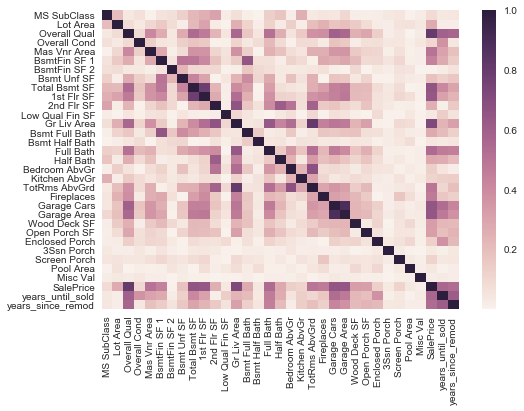

In [13]:
%matplotlib inline
import seaborn as sns
num_df = test_df.select_dtypes(include=['float','integer'])
sns.heatmap(num_df.corr().abs())

The following sets of features correlate strongly with each other:
    - Garage Area - Garage Cars
    - 1st Flr SF - Total Bsmt SF
    - TotRms AbvGrd - Gr Liv Area
Of these sets, we'll keep 'Garage Area', '1st Flr SF', 'Gr Liv Area'. In each pair, this column is at least as granular as the other in values.

In [14]:
# Drop features that are highly correlated with other features
test_df = test_df.drop(['Garage Cars', 'Total Bsmt SF', 'TotRms AbvGrd'],axis=1)
num_df = num_df.drop(['Garage Cars', 'Total Bsmt SF', 'TotRms AbvGrd'],axis=1)

We'll select only features that have a strong enough correlation with 'SalePrice'.

In [15]:
correlations = num_df.corr()['SalePrice'].abs().sort_values()
correlations

BsmtFin SF 2         0.007565
Misc Val             0.019183
3Ssn Porch           0.033305
Pool Area            0.035491
Low Qual Fin SF      0.037836
Bsmt Half Bath       0.045720
MS SubClass          0.086906
Overall Cond         0.103296
Screen Porch         0.115556
Kitchen AbvGr        0.120938
Enclosed Porch       0.129339
Bedroom AbvGr        0.139766
Bsmt Unf SF          0.185632
2nd Flr SF           0.257132
Lot Area             0.270047
Bsmt Full Bath       0.280989
Half Bath            0.284458
Open Porch SF        0.322075
Wood Deck SF         0.326911
BsmtFin SF 1         0.444721
Fireplaces           0.474878
Mas Vnr Area         0.506895
years_since_remod    0.542125
Full Bath            0.544486
years_until_sold     0.565492
1st Flr SF           0.642902
Garage Area          0.648050
Gr Liv Area          0.719463
Overall Qual         0.805236
SalePrice            1.000000
Name: SalePrice, dtype: float64

In [16]:
# Drop numerical columns with "SalePrice" correlation < .4.
test_df = test_df.drop(correlations[correlations < .4].index,axis=1)

Let's take a look at categorical columns and determine which ones should be used based on the following criteria:

- Not too many unique values (as to now blow up the dataset)
- Not too low of variance (if all houses fall into same category, its not a useful feature)
    

In [17]:
# Select categorical columns
nominal_cols = ["PID","MS SubClass","MS Zoning","Street","Alley","Land Contour","Lot Config","Neighborhood","Condition 1","Condition 2","Bldg Type","House Style","Roof Style","Roof Matl","Exterior 1st","Exterior 2nd","Mas Vnr Type","Foundation","Heating","Central Air","Garage Type","Misc Feature","Sale Type"]
ordinal_cols = ["Lot Shape","Utilities","Land Slope","Exter Qual","Exter Cond","Bsmt Qual","Bsmt Cond","Bsmt Exposure","BsmtFin Type 1","BsmtFin Type 2","Heating QC","Electrical","Kitchen Qual","Functional","Fireplace Qu","Garage Finish","Garage Qual","Garage Cond","Paved Drive","Pool QC","Fence","Sale Condition"]
ordinal_numeric_cols = ["Overall Qual","Overall Cond"]
cat_cols = nominal_cols + ordinal_cols

In [18]:
transform_cat_cols = []
for column in cat_cols:
    if column in test_df.columns:
        transform_cat_cols.append(column)
cat_stats = test_df[transform_cat_cols].describe()
unique_stats = cat_stats.loc['unique']

# Only select categorical columns with <= 10 unique values
test_df = test_df.drop(unique_stats[unique_stats > 10].index,axis=1)

# Get rid of any categorical columns where the most frequent value is more than 95% of the total
top_percent_of_total = cat_stats.loc['freq']/cat_stats.loc['count']
test_df = test_df.drop(top_percent_of_total[top_percent_of_total > .95].index,axis=1)

test_df.describe(include=['object'])

,MS Zoning,Lot Shape,Land Contour,Lot Config,Condition 1,Bldg Type,House Style,Roof Style,Exter Qual,Exter Cond,Foundation,Heating QC,Central Air,Kitchen Qual,Functional,Paved Drive
count,2925,2925,2925,2925,2925,2925,2925,2925,2925,2925,2925,2925,2925,2925,2925,2925
unique,7,4,4,5,9,5,8,6,4,5,6,5,2,5,8,3
top,RL,Reg,Lvl,Inside,Norm,1Fam,1Story,Gable,TA,TA,PConc,Ex,Y,TA,Typ,Y
freq,2268,1859,2631,2138,2519,2420,1480,2320,1799,2544,1305,1490,2729,1494,2723,2647


Now we need to transform these into categorical columns and then create dummy columns.

In [19]:
# Convert to category columns
text_cols = test_df.select_dtypes(include=['object'])
for col in text_cols:
    test_df[col] = test_df[col].astype('category')
test_df = pd.concat([test_df,pd.get_dummies(test_df.select_dtypes(include=['category']))],axis=1)

Our dataframe now has a good set of useable features in numeric format.

Let's update our select_features function:

In [21]:
def select_features(df,correlation_threshold=0.4,uniqueness_threshold=10):
    # Drop features that are highly correlated with other features
    df = df.drop(['Garage Cars', 'Total Bsmt SF', 'TotRms AbvGrd'],axis=1)
        
    correlations = num_df.corr()['SalePrice'].abs().sort_values()
    # Drop numerical columns with "SalePrice" correlation < our threshold.
    df = df.drop(correlations[correlations < correlation_threshold].index,axis=1)
    
    # Select categorical columns.
    nominal_cols = ["PID","MS SubClass","MS Zoning","Street","Alley","Land Contour","Lot Config","Neighborhood","Condition 1","Condition 2","Bldg Type","House Style","Roof Style","Roof Matl","Exterior 1st","Exterior 2nd","Mas Vnr Type","Foundation","Heating","Central Air","Garage Type","Misc Feature","Sale Type"]
    ordinal_cols = ["Lot Shape","Utilities","Land Slope","Exter Qual","Exter Cond","Bsmt Qual","Bsmt Cond","Bsmt Exposure","BsmtFin Type 1","BsmtFin Type 2","Heating QC","Electrical","Kitchen Qual","Functional","Fireplace Qu","Garage Finish","Garage Qual","Garage Cond","Paved Drive","Pool QC","Fence","Sale Condition"]
    cat_cols = nominal_cols + ordinal_cols
    
    # Transform categorical columns.
    transform_cat_cols = []
    for column in cat_cols:
        if column in df.columns:
            transform_cat_cols.append(column)
    cat_stats = df[transform_cat_cols].describe()
    unique_stats = cat_stats.loc['unique']

    # Drop categorical columns with more unique values than our threshold
    df = df.drop(unique_stats[unique_stats > uniqueness_threshold].index,axis=1)

    # Get rid of any categorical columns where the most frequent value is more than 95% of the total
    top_percent_of_total = cat_stats.loc['freq']/cat_stats.loc['count']
    df = df.drop(top_percent_of_total[top_percent_of_total > .95].index,axis=1)
    
    # Convert to category columns and create dummy columns
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    df = pd.concat([df,pd.get_dummies(df.select_dtypes(include=['category']))],axis=1)
    
    
    return df

transformed_data = transform_features(data)
filtered_data = select_features(transformed_data)
rmse = train_and_test(filtered_data)
print(rmse)

26616.1191074


### Train and Test

We'll update the 'train_and_test' function to do arbitrary k-fold validation.

In [22]:
from sklearn.model_selection import KFold

def train_and_test(df,k=0):
    numeric_df = df.select_dtypes(include=['integer','float'])
    features = numeric_df.columns.drop('SalePrice')
    lr = LinearRegression()
    
    if k == 0:
        #split data into train and test
        train = numeric_df[:1460]
        test = numeric_df[1460:]

        #fit model to train data and test
        lr.fit(train[features],train['SalePrice'])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test['SalePrice'],predictions)
        rmse = np.sqrt(np.absolute(mse))

        return rmse
    
    if k == 1:
        # Randomize and split dataset
        numeric_df = numeric_df.reindex(np.random.permutation(numeric_df.index))
        fold_one = numeric_df[:1460]
        fold_two = numeric_df[1460:]
        
        # Train on 1 test on 2
        lr.fit(fold_one[features],fold_one['SalePrice'])
        predictions = lr.predict(fold_two[features])
        rmse_one = np.sqrt(mean_squared_error(fold_two['SalePrice'],predictions))
        
        # Train on 2 test on 1
        lr.fit(fold_two[features],fold_two['SalePrice'])
        predictions = lr.predict(fold_one[features])
        rmse_two = np.sqrt(mean_squared_error(fold_one['SalePrice'],predictions))
        
        #Average
        return (rmse_one + rmse_two) / 2
    
    # For k > 1
    kf = KFold(n_splits=k, shuffle=True)
    rmse_list = []
    # Iterate over all splits gathering train/test errors
    for train_index, test_index, in kf.split(numeric_df):
        train = numeric_df.iloc[train_index]
        test = numeric_df.iloc[test_index]
        lr.fit(train[features],train['SalePrice'])
        predictions = lr.predict(test[features])
        rmse = np.sqrt(mean_squared_error(test['SalePrice'],predictions))
        rmse_list.append(rmse)        
    # Return average of errors
    return np.mean(rmse_list)
        

transformed_data = transform_features(data)
filtered_data = select_features(transformed_data)
rmse = train_and_test(filtered_data,10)
print(rmse)

25633.4551102


In [23]:
for k in range(25):
    print(k,train_and_test(filtered_data,k))

0 26616.1191074
1 26206.7996274
2 27150.8245281
3 25795.7228333
4 25950.3525996
5 26219.2091793
6 25778.7666991
7 25817.9794362
8 25884.4982544
9 25779.5171988
10 25839.9275421
11 25635.2578047
12 25778.0058465
13 25579.5460939
14 25762.3528761
15 25676.6477955
16 25739.5539871
17 25608.5952312
18 25798.385306
19 25580.4312175
20 25581.8517671
21 25664.6058759
22 25574.4516853
23 25561.0178442
24 25431.8624757


### Further Feature Engineering

Some ideas for new features:
    - Season Sold
    - Day of Week Sold
    
Simplify existing features (e.g. 1-10 scale to 1-3 scale)
Combine existing features (Overall Grade = Qual * Condition, total bathrooms)
Polynomials (2,3,sq) on top features (10)
    
    

## Improve feature selection:

Research ways of doing feature selection better with categorical columns.